Please note that the file libdevice.10.bc is only in the Titanic folder as a workaround to a bug. The file is not automatically found at its proper location (/usr/lib/cuda/nvvm/libdevice/libdevice.10.bc) so it is placed here instead.

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
train = pd.read_csv("train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
train["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [20]:
train = pd.read_csv("train.csv")

# Map female -> 0 and male -> 1
train["Sex"] = train["Sex"].map({"female": 0,
                                 "male": 1})

# In "Embarked" column there are {S:644, C:168, Q:77, NaN:2} so we map S -> 0, C -> 1, Q -> 2, NaN -> 0
embarked_map = {"S": 0,
              "C": 1,
              "Q": 2}

train["Embarked"] = train["Embarked"].map(embarked_map)
train.Embarked = train.Embarked.fillna(0)

# Remove categories that don't correspond to survival rate.
train = train.drop("PassengerId", axis=1)
train = train.drop("Name", axis=1)
train = train.drop("Ticket", axis=1)
train = train.drop("Cabin", axis=1)

# Put labels in their own dataframe
labels = train.pop("Survived")

train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,0.0
1,1,0,38.0,1,0,71.2833,1.0
2,3,0,26.0,0,0,7.9250,0.0
3,1,0,35.0,1,0,53.1000,0.0
4,3,1,35.0,0,0,8.0500,0.0


In [21]:
train.Age = (train.Age - train.Age.mean()) / train.Age.std()
train.Fare = (train.Fare - train.Fare.mean()) / train.Fare.std()
train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,-0.530005,1,0,-0.502163,0.0
1,1,0,0.571430,1,0,0.786404,1.0
2,3,0,-0.254646,0,0,-0.488580,0.0
3,1,0,0.364911,1,0,0.420494,0.0
4,3,1,0.364911,0,0,-0.486064,0.0


In [22]:
# Replace null age values with a random number sampled from the continuous distribution [-1, +1] (this is mean +/- std of the ages)
null_ages = np.isnan(train.Age)
null_ages_count = len(null_ages)
random_ages = np.random.random_sample(null_ages_count)
random_ages = (random_ages - 0.5) * 2
train.Age[null_ages] = random_ages

/tmp/ipykernel_19733/3058668987.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train.Age[null_ages] = random_ages
/tmp/ipykernel_19733/3058668987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [41]:
# Set aside 200 samples for validation
train_val = train[:200]
labels_val = labels[:200]

# The remaining samples are for training
partial_train = train[200:]
partial_labels = labels[200:]

model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=keras.optimizers.RMSprop(0.01),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [42]:
history = model.fit(
    partial_train,
    partial_labels,
    epochs=25,
    validation_data = (train_val, labels_val)
)

Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4536 - loss: 1.1772 - val_accuracy: 0.6500 - val_loss: 0.6427
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6495 - loss: 0.5991 - val_accuracy: 0.6850 - val_loss: 0.5850
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7588 - loss: 0.5176 - val_accuracy: 0.7500 - val_loss: 0.5463
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7511 - loss: 0.5114 - val_accuracy: 0.7450 - val_loss: 0.5313
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7597 - loss: 0.5120 - val_accuracy: 0.7750 - val_loss: 0.5184
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7824 - loss: 0.5206 - val_accuracy: 0.7550 - val_loss: 0.5166
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7734 - loss: 0.4767 - val_accuracy: 0.7750 - val_loss: 0.5023
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8110 - loss: 0.4606 - val_accuracy: 0.7600 - val_loss

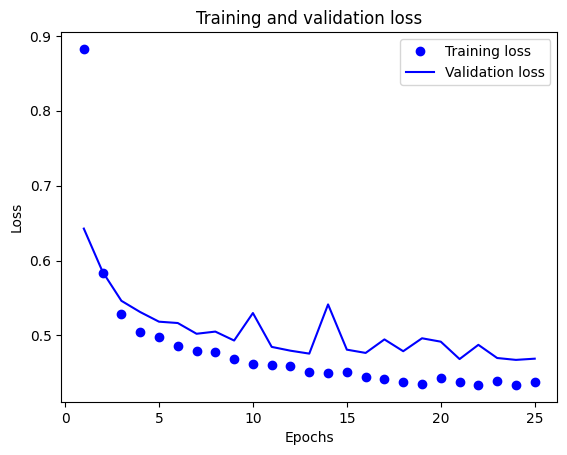

In [44]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()